In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import matplotlib.gridspec as gridspec
from math import radians, pi
plt.style.use(['science','no-latex'])
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# import the modules
# import sys
# sys.path.append('../')
import estimator as es

In [3]:
# initialize the orekit
import orekit
vm = orekit.initVM()

from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()

In [4]:
from java.util import Arrays
from orekit import JArray_double
from org.orekit.frames import  FramesFactory
from org.orekit.data import DataProvidersManager, ZipJarCrawler
from org.orekit.time import TimeScalesFactory, AbsoluteDate
from org.orekit.orbits import KeplerianOrbit, CartesianOrbit, PositionAngle, OrbitType
from org.orekit.utils import Constants
from org.orekit.utils import PVCoordinatesProvider
from org.orekit.propagation.analytical import EcksteinHechlerPropagator
from org.orekit.propagation.analytical.tle import TLEPropagator
from org.orekit.propagation.conversion import FiniteDifferencePropagatorConverter
from org.orekit.propagation.conversion import TLEPropagatorBuilder
from datetime import datetime
from org.orekit.propagation import SpacecraftState
from org.orekit.orbits import OrbitType, PositionAngle
from org.orekit.propagation.numerical import NumericalPropagator
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.utils import IERSConventions
from org.hipparchus.geometry.euclidean.threed import Vector3D,SphericalCoordinates
from org.orekit.utils import PVCoordinates

In [5]:
days=3
dt = 240.0
trange =np.arange(0,86400*days,dt)
nrange = int(86400*days/dt)

with open('../data/ISS/ISS.oem', 'r') as file:
    data = file.readlines() # read a list of lines into data
    print(data[40])
stateVec0=np.loadtxt('../data/ISS/ISS.oem',skiprows=40,usecols=(1,2,3,4,5,6),max_rows=nrange)*1000
altitude0 = np.array([es.altitude(stateVec0[i]) for i in range(nrange)])
print(stateVec0[0][0:3])
print(stateVec0[0][3:6])


2022-12-14T12:00:00.000 2524.798546369910 3547.480346098530 -5223.286743469080 -6.88150162273442 3.11385050390907 -1.21596824167983

[ 2524798.54636991  3547480.34609853 -5223286.74346908]
[-6881.50162273  3113.85050391 -1215.96824168]


In [6]:
# Some Constants
ae = Constants.WGS84_EARTH_EQUATORIAL_RADIUS
mu = Constants.WGS84_EARTH_MU
utc = TimeScalesFactory.getUTC()


# set the initial state
pos0 = [2524798.54636991,  3547480.34609853, -5223286.74346908]
vel0 = [-6881.50162273,  3113.85050391, -1215.96824168]
year = 2022
month = 12
day = 14
hour = 12
minute = 0
second = 0.00

inertialFrame = FramesFactory.getEME2000() # inertial frame for orbit definition
position  = Vector3D(pos0[0], pos0[1], pos0[2])
velocity  = Vector3D(vel0[0], vel0[1], vel0[2])
pvCoordinates = PVCoordinates(position, velocity)

satellite_mass = 472355.0 # kg
B_star = 0.0
Cd = 2.0 # drag coeffiecient
A = 1457.20 #2*satellite_mass*B_star/(0.1570*Cd) # in m^2

initialDate = AbsoluteDate(year, month, day, hour, minute, second, TimeScalesFactory.getUTC())


initialOrbit = KeplerianOrbit(pvCoordinates,
                                inertialFrame,
                                initialDate,
                                Constants.WGS84_EARTH_MU)

initialState = SpacecraftState(initialOrbit, satellite_mass) 
initial_altitude = SphericalCoordinates(position).r

print(initialOrbit)

Keplerian parameters: {a: 6790092.102571101; e: 0.0015463708199796814; i: 51.65750773429317; pa: -264.87944425808627; raan: 162.96898899696222; v: 163.2132110393854;}


In [25]:
# set the step size and the spatial tolerance
minStep = 0.001;
maxstep = 1000.0;
initStep = 60.0

#The spatial tolerance can be specified (meters)
positionTolerance = 1.0
orbitType = OrbitType.CARTESIAN
tol = NumericalPropagator.tolerances(positionTolerance, initialOrbit, orbitType)


#The actual integrator DormandPrince853, is part of the Hipparchos library.
integrator = DormandPrince853Integrator(minStep, maxstep, 
    JArray_double.cast_(tol[0]),  # Double array of doubles needs to be casted in Python
    JArray_double.cast_(tol[1]))
integrator.setInitialStepSize(initStep)

propagator_num = NumericalPropagator(integrator)
propagator_num.setOrbitType(orbitType)
propagator_num.setInitialState(initialState)
propagator_num.removeForceModels() # remove all initial force model

In [26]:
# We are adding a gravity field model. Other force models can be added as well.
from org.orekit.bodies import  OneAxisEllipsoid
from org.orekit.bodies import CelestialBodyFactory
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel
from org.orekit.forces.drag import DragForce
from org.orekit.forces.drag import IsotropicDrag
from org.orekit.models.earth.atmosphere import HarrisPriester

# add the gravity
itrf    = FramesFactory.getITRF(IERSConventions.IERS_2010, True) # International Terrestrial Reference Frame
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                         Constants.WGS84_EARTH_FLATTENING,
                         itrf)
gravityProvider = GravityFieldFactory.getNormalizedProvider(2, 2) # geopotential order of 8
propagator_num.addForceModel(HolmesFeatherstoneAttractionModel(earth.getBodyFrame(), gravityProvider))

# Get the position of the sun in the Earth centered coordinate system EME2000
sun = CelestialBodyFactory.getSun() 
sun = PVCoordinatesProvider.cast_(sun)
sun.getPVCoordinates(initialDate, FramesFactory.getEME2000()).getPosition()


# add the atmopheric drag using with HarrisPriester atmoshpere model
atmosphere = HarrisPriester(sun,earth)
spacecraft = IsotropicDrag(A,Cd)
dragForce = DragForce(atmosphere,spacecraft)
propagator_num.addForceModel(dragForce)

In [27]:
## Create time vector and start the propagator

startDate = AbsoluteDate(year, month, day, hour, minute, second, utc)
# simu_time = np.linspace(60,60*4*360,360*4)

#Overall duration in seconds for extrapolation
duration = 86400*days
step_time = dt #  

# Time array in orekit AbsoluteDate format
t = [startDate.shiftedBy(float(dt)) \
        for dt in np.arange(0, duration, step_time)]
state = [propagator_num.propagate(tt) for tt in t]
pos = [propagator_num.propagate(tt).getPVCoordinates().getPosition() for tt in t]
vel = [propagator_num.propagate(tt).getPVCoordinates().getVelocity() for tt in t]

In [28]:
# save the simulation data
data = []
period = np.arange(0,duration,step_time,dtype='int')

for i,position in enumerate(period):
    data.append([period[i],pos[i].x,pos[i].y,pos[i].z,vel[i].x,vel[i].y,vel[i].z])
    
np.savetxt('orekit.out',data,fmt='%f',header='time[s]  x   y   z   vx   vy   vz [m] ')

Period in min:
TLE: 105.15008000000002
Orekit 105.21712


Text(0, 0.5, 'distance in [km]')

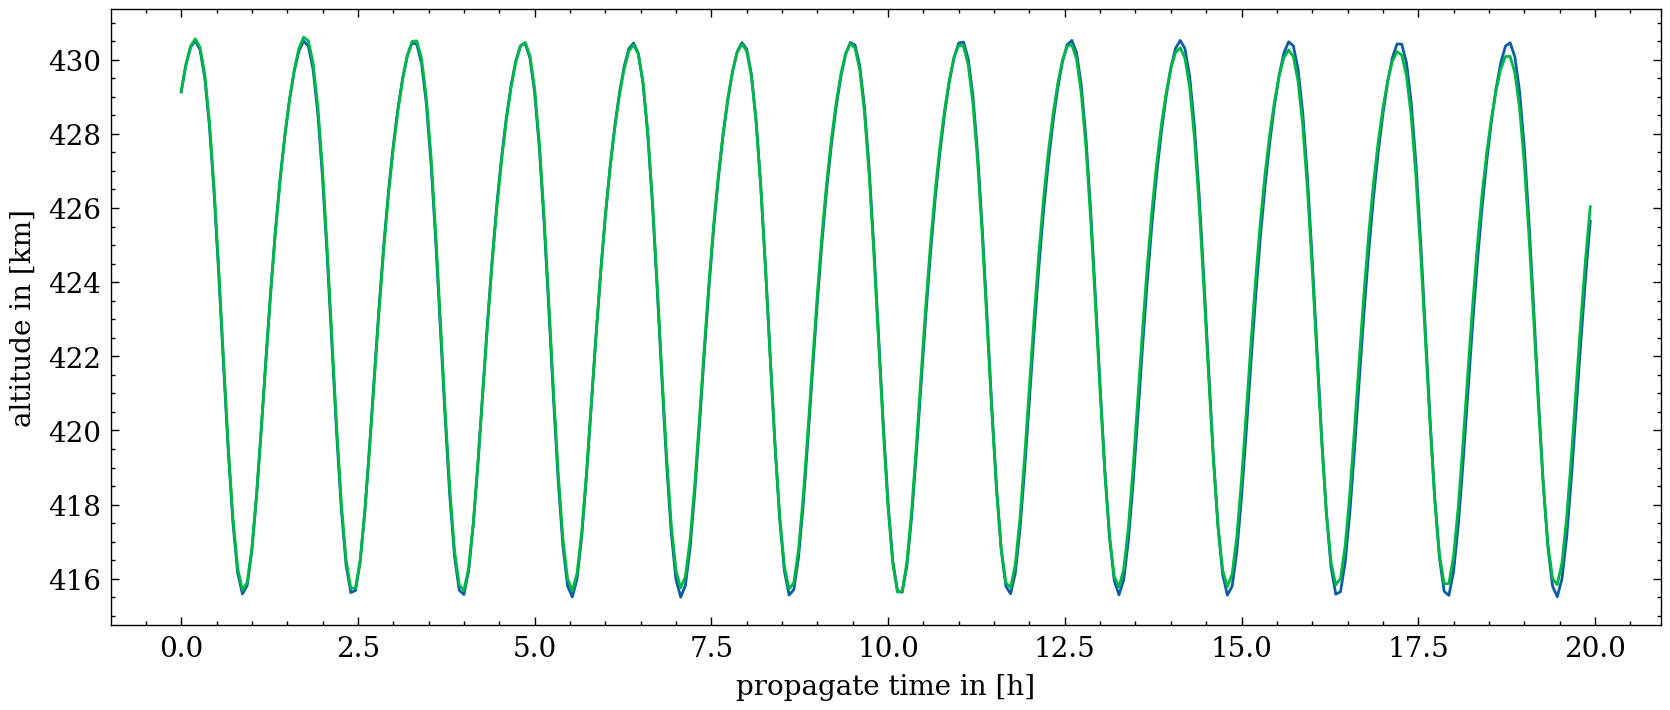

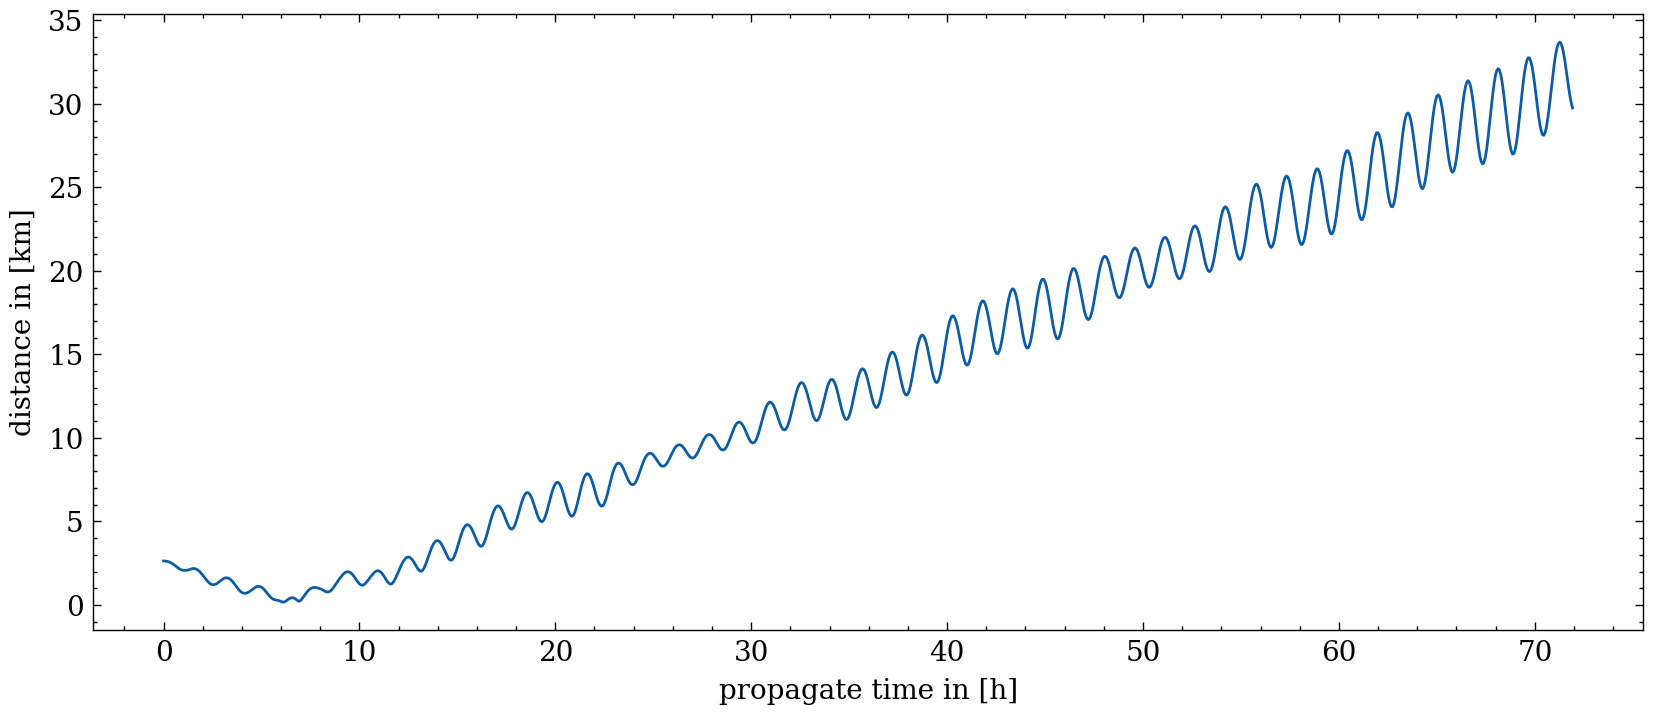

In [29]:
# plot the Orekit simulation data and OEM data

stateVec = np.loadtxt('orekit.out',skiprows = 1,usecols=(1,2,3,4,5,6))[0:nrange]
altitude = np.array([es.altitude(stateVec[i]) for i in range(nrange)])

distance = np.array([es.distance(stateVec[i],stateVec0[i]) for i in range(len(stateVec))])

a=300

print('Period in min:')
print('TLE:',es.period(altitude0,dt)/60)
print('Orekit',es.period(altitude,dt)/60)

plt.figure(figsize=(10,4))
plt.plot(trange[0:a]/3600,altitude[0:a]/1000)
plt.plot(trange[0:a]/3600,altitude0[0:a]/1000)
plt.xlabel('propagate time in [h]') 
plt.ylabel('altitude in [km]')

plt.figure(figsize=(10,4))
plt.plot(trange/3600,distance/1000)
plt.xlabel('propagate time in [h]') 
plt.ylabel('distance in [km]')


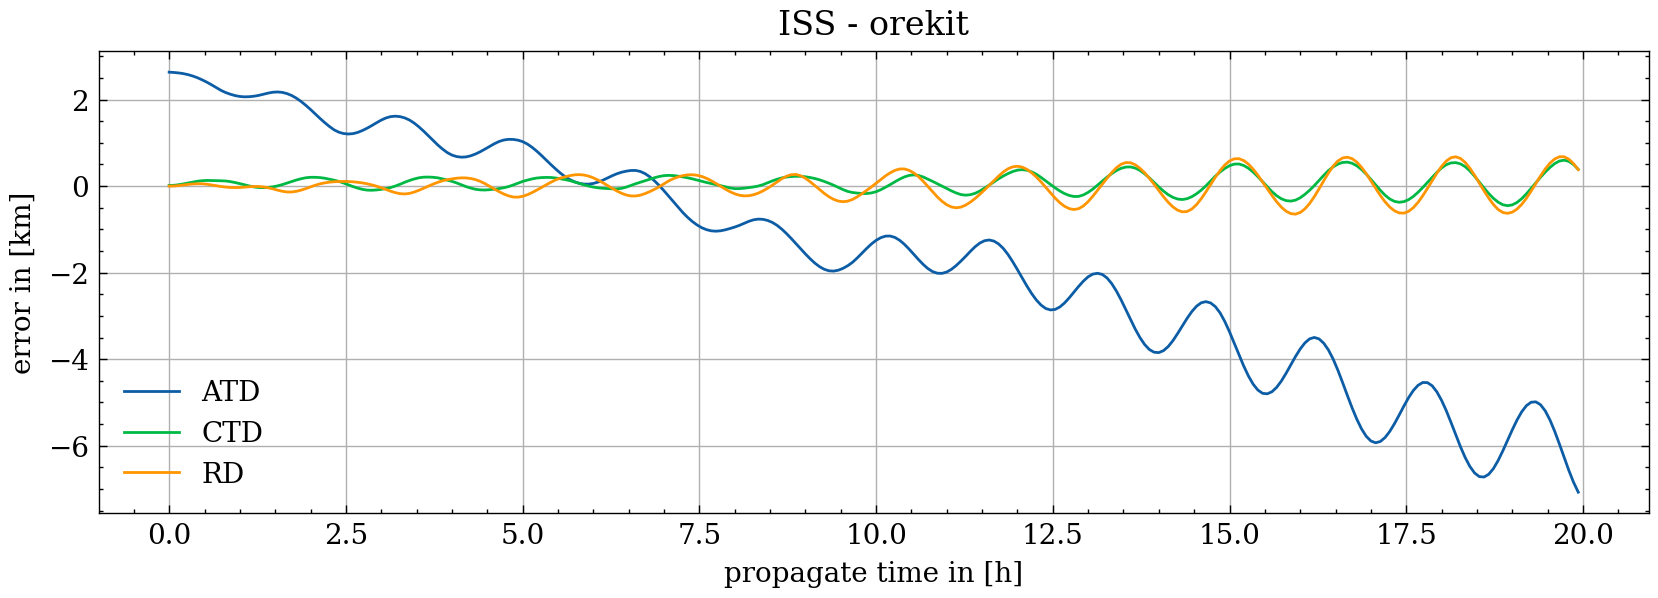

In [30]:
error = [[],[],[]] # along track, cross track and radial difference
errortype = ['ATD','CTD','RD']

for i in range(1080):
    for n in range(3):
        error[n].append(es.errorEstimator(stateVec0[i],stateVec[i])[errortype[n]]/1000)
        
        
plt.figure(figsize=(10,3))
for n in range(3):      
    plt.plot(trange[0:a]/3600,error[n][0:a],label=errortype[n])
plt.xlabel('propagate time in [h]') 
plt.ylabel('error in [km]')
plt.title('ISS - orekit')
plt.grid(1)
plt.legend(loc=3)
plt.show()